In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


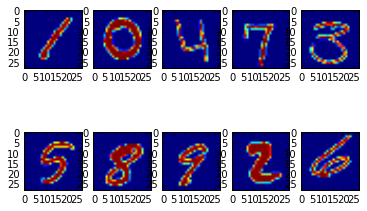

In [74]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as P
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.cross_validation import cross_val_score
%matplotlib inline

def display_digit(df):
    num = df.drop_duplicates('label')
    v = num.drop('label', axis=1).values
    r, _ = num.shape
    imgs = map(lambda x :np.reshape(x, (28,28)), v)
    fig = P.figure()
    for i in range(r):
        a = fig.add_subplot(2, r/2, i+1)
        P.imshow(imgs[i])
    P.show()

### This function computes minimum distance
### between 2 matrices passed between all pairs in those matrices
def l2norm(a1, a2):
    tp = np.empty((0,2))
    fp = np.empty((0,2))
    for i in xrange(a1.shape[0]):
        mindist = 0
        is_tp = 0
        for j in xrange(a2.shape[0]):
            dist = np.linalg.norm(a1[i][1:] - a2[j][1:])
            if ((i != j) and (dist < mindist)):
                mindist = dist
                if (a1[i][0] == a2[j][0]):
                    is_tp = 1
                else:
                    is_tp = 0
        if (is_tp == 1):
            tp = np.append(tp, np.array([[is_tp, mindist]]), axis = 0)
        else:
            fp = np.append(fp, np.array([[is_tp, mindist]]), axis = 0)
    return (tp, fp)
    
if __name__ == '__main__': 
    df = pd.read_csv('train.csv', header = 0)
    df_test = pd.read_csv('test.csv', header = 0)
    # Write a function to display an MNIST digit. Display one of each digit
    display_digit(df)

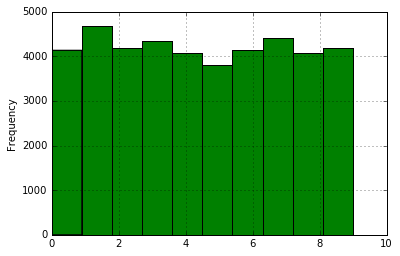

[4132 4684 4177 4351 4072 3795 4137 4401 4063 4188]
42000.0
Prior probability is :
[ 0.09838095  0.11152381  0.09945238  0.10359524  0.09695238  0.09035714
  0.0985      0.10478571  0.0967381   0.09971429]


In [12]:
    #Examine the prior probability of the classes in the training data. 
    #Is it uniform across the digits?
    # Display a normalized histogram of digit counts. Is it even?
    P.figure()    
    df['label'].plot(kind='hist')
    df['label'].hist()
    P.show()
    nbins = np.bincount(df['label'])
    total = np.sum(nbins, dtype=np.float32)
    print nbins
    print total
    print "Prior probability is :"
    print nbins/total

In [13]:
    #Pick one example of each digit from your training data. Then, for each sample digit, compute
    #and show the best match (nearest neighbor) between your chosen sample and the rest of
    #the training data. Use L2 distance between the two images’ pixel values as the metric. This
    #probably won’t be perfect, so add an asterisk next to the erroneous examples.
    train = df.values

    empty_shape = np.shape(train[0][1:])

    for i in xrange(v.shape[0]):
        mindist = np.linalg.norm(v[i][1:])
        val = np.empty(empty_shape)
        for j in xrange(train.shape[0]):
            dist = np.linalg.norm(v[i][1:] - train[j][1:])
            if (dist > 0.0 and dist < mindist):
                mindist = dist
                val = train[j]
        if (v[i][0] != val[0]):
            print "Min Distance " + str(dist) + " *Val " + str(v[i][0]) + " " + str(val[0])
        else:
            print "Min Distance " + str(dist) + " Val " + str(v[i][0]) + " " + str(val[0])

Min Distance 2177.98002746 Val 1 1
Min Distance 3094.40802093 Val 0 0
Min Distance 2178.54928794 Val 4 4
Min Distance 1988.77550266 Val 7 7
Min Distance 2384.5045607 *Val 3 5
Min Distance 2469.7473555 Val 5 5
Min Distance 2583.85545261 Val 8 8
Min Distance 2122.97362207 Val 9 9
Min Distance 2691.08435394 Val 2 2
Min Distance 2420.30473288 Val 6 6


(4131, 785)


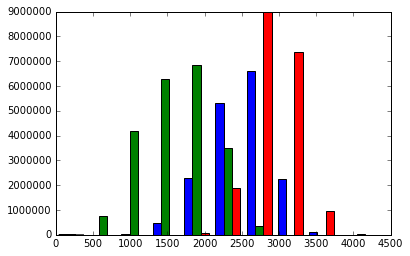

In [24]:
    #Consider the case of binary comparison between the digits 0 and 1. Ignoring all the other
    #digits, compute the pairwise distances for all genuine matches and all impostor matches,
    #again using the L2 norm. Plot histograms of the genuine and impostor distances on the same
    #set of axes. 
    df_0 = df.loc[df['label'] == 0]
    df_1 = df.loc[df['label'] == 1]
    df_0_1 = df_0.append(df_1).values
    
    ## Subsampling 100 rows to test further code
    #rows_0 = np.random.choice(df_0.index.values, 100)
    #rows_1 = np.random.choice(df_1.index.values, 100)
    sample0_df = df_0.ix[:][1:].values
    sample1_df = df_1.ix[:][1:].values
    print sample0_df.shape
    #sample_0_1 = sample0_df.append(sample1_df).values
    #tp, fp = l2norm(sample_0_1, sample_0_1)
    #tp, fp = l2norm(df_0_1, df_0_1)
    genuine_matches0 = [np.linalg.norm(a-b) for a in sample0_df for b in sample0_df]
    genuine_matches1 = [np.linalg.norm(a-b) for a in sample1_df for b in sample1_df]
    impostor_matches = [np.linalg.norm(a-b) for a in sample0_df for b in sample1_df]
    P.hist((genuine_matches0, genuine_matches1, impostor_matches))
    P.show()

(8816, 785)
(4131, 4131) (4683, 4683) (4131, 4683)
(8814,)


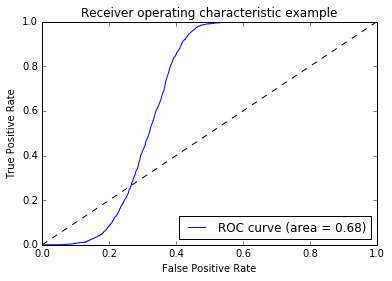

In [59]:
    # Generate an ROC curve from the above sets of distances. What is the equal error rate? What
    # is the error rate of a classifier that simply guesses randomly?
    print df_0_1.shape
    y_labels = df_0['label'].append(df_1['label']).values
    gen02d = np.reshape(genuine_matches0, (sample0_df.shape[0], sample0_df.shape[0]))
    gen12d = np.reshape(genuine_matches1, (sample1_df.shape[0], sample1_df.shape[0]))
    imp2d = np.reshape(impostor_matches, (sample0_df.shape[0], sample1_df.shape[0]))
    print gen02d.shape, gen12d.shape, imp2d.shape
    y_scores0 = np.divide(np.sum(imp2d, axis=1), np.sum(gen02d))
    y_scores1 = np.divide(np.sum(imp2d, axis=0), np.sum(gen12d))
    y_scores = np.hstack((y_scores0, y_scores1))
    print y_scores.shape
    fpr, tpr, _ = roc_curve(y_labels[:-2], y_scores)
    roc_auc = auc(fpr, tpr)
    P.plot(fpr, tpr,label='ROC curve (area = %0.2f)' % roc_auc)
    P.plot([0, 1], [0, 1], 'k--')
    P.xlim([0.0, 1.0])
    P.ylim([0.0, 1.0])
    P.xlabel('False Positive Rate')
    P.ylabel('True Positive Rate')
    P.title('Receiver operating characteristic example')
    P.legend(loc="lower right")
    P.show()

In [72]:
    # Implement a K-NN classifier.
    knc = KNeighborsClassifier(n_neighbors=20, weights='uniform', algorithm='auto',
                                leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=2)
    print train.shape
    knc = knc.fit(train[:, 1:], train[:,0])
    cross_score = cross_val_score(knc, train[:, 1:], train[:,0], cv=3, n_jobs=2)
    print cross_score

(42000, 785)
[ 0.95201371  0.95142163  0.95277897]


In [73]:
    knc_mod = KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='auto',
                                leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=2)
    knc_mod = knc_mod.fit(train[:, 1:], train[:,0])
    cross_score = cross_val_score(knc_mod, train[:, 1:], train[:,0], cv=3, n_jobs=2)
    print cross_score

[ 0.96208226  0.96270896  0.96420917]


In [75]:
    test_values = knc_mod.predict(df_test.values)

AttributeError: 'module' object has no attribute 'to_csv'

In [84]:
    print test_values.shape
    np.savetxt('test_out.csv', np.transpose(np.vstack((np.arange(1,test_values.shape[0]+1), test_values))),
               fmt='%d', header='ImageId,Label', delimiter=',', comments='')

(28000,)
